In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, make_scorer
%matplotlib inline 

# 1. Preparing Data

### Loading HH Survey Data

In [2]:
hh_data = pd.read_csv("../Data/Intermediate_files/hh_data_2011_cluster_minHH.csv")

In [3]:
hh_data.head()

,Unnamed: 0,gpsLatitude,gpsLongitude,cons,n,poor,n2,poor_majority,i,j
0,1,-1.404995,29.949390,2.316352,12,0.250000,12,0,25194,9169
1,3,-1.340851,29.768257,1.594851,11,0.545455,11,1,25172,9161
2,4,-1.255216,30.056820,3.852909,10,0.300000,10,0,25207,9151
3,5,-1.241430,29.961166,2.776385,8,0.500000,8,1,25195,9149
4,8,-1.166219,29.794294,2.971421,7,0.142857,7,0,25175,9140


### Loading CNN features

In [4]:
CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_ResNet_tf_16pertile.csv")

### Merging features with survey data with the grid

In [5]:
data = hh_data.merge(CNN_features,on=["i","j"])

In [6]:
data = data.sample(frac=1, random_state=1783).reset_index(drop=True) #Shuffling the data

In [7]:
data_features = data[list(set(data.columns) - set(hh_data.columns) - set(['index']))] # take only the CNN features

In [8]:
data_features.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True) # legacy columns

C:\Users\lorenzo.riches\AppData\Local\Continuum\anaconda3\envs\py35env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
data_features.shape

(309, 2048)

### Defining predictors and predicting variables

In [10]:
y = data["cons"].values #Average normalized consumption per cluster
y = y[y > 0]
y = np.log(y) #Log-normal distribution

### Dimensionality Redux

In [40]:
pca = PCA(n_components=100)
X = pca.fit_transform(data_features)

In [12]:
### Normalize

In [41]:
from sklearn.preprocessing import normalize
X = normalize(X)

In [42]:
X.shape

(309, 100)

In [43]:
y.shape

(309,)

# 2. Predicting Continuous Indicator

### fit on first 200 points

In [56]:
model=Ridge(alpha=1.7)

In [57]:
model.fit(X[:200,:], y[:200])

Ridge(alpha=1.7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### Evaluate

In [58]:
print('train r2: ', model.score(X[:200,:], y[:200]))
print('test r2: ', model.score(X[200:,:], y[200:]))

train r2:  0.609522509329
test r2:  0.352255283466


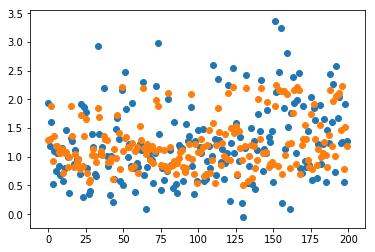

In [59]:
plt.scatter(range(0,200), y[:200])
plt.scatter(range(0,200), model.predict(X[:200,:]))

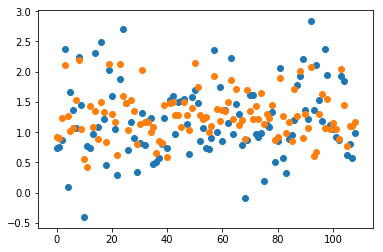

In [60]:
plt.scatter(range(0,109), y[200:])
plt.scatter(range(0,109), model.predict(X[200:,:]))

# 3. Predictions

In [61]:
yhat_test = np.exp(model.predict(X[200:]))
y_test = np.exp(y[200:])

In [62]:
test_res = pd.DataFrame({'pred': yhat_test, 'true': y_test})

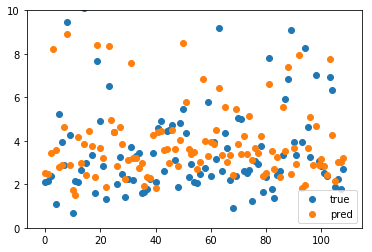

In [64]:
plt.scatter(range(0,109), y_test, label='true')
plt.scatter(range(0,109), yhat_test, label='pred')
plt.ylim((0,10))
plt.legend()
plt.show()

### Mapping Results

In [65]:
results = hh_data[['gpsLatitude', 'gpsLongitude', 'cons']]
results['pred'] = np.exp(model.predict(X))

C:\Users\lorenzo.riches\AppData\Local\Continuum\anaconda3\envs\py35env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
# expanding rows depending on values in cons/pred

In [66]:
plot_df = results.groupby(['gpsLatitude', 'gpsLongitude'], as_index=False).sum()

In [68]:
plot_df = plot_df.loc[plot_df.index.repeat(plot_df['cons'].astype(int))].reset_index(drop=True)

In [76]:
import gmplot
gmap = gmplot.GoogleMapPlotter(1.268255, 32.541539, 8)
gmap.heatmap(plot_df['gpsLatitude'], plot_df['gpsLongitude'], dissipating=True, threshold=1, radius=50, gradient=None, opacity=0.6)
gmap.draw("mymap.html")